# Dialogue Act Analysis (2019)

In [107]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 10)

import re
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats

from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold

from collections import Counter
import statsmodels.api as sm
import statsmodels.formula.api as smf

import itertools

Populating the interactive namespace from numpy and matplotlib


## Load data
Read all the tags from Nikos' file. From 1st column obtain filename, speaker and lineno

In [51]:
tags = pd.read_csv("../data/DA_ENGLISH_CDC/final_acts_transcribed.txt", sep = "\t", names=['filename.role', "tag"])
tags.head()

,filename.role,tag
0,f_1.000001.Provider,Question
1,f_1.000002.Caregiver,Other
2,f_1.000003.Provider,Statement
3,f_1.000004.Caregiver,Backchannel
4,f_1.000005.Provider,Statement


In [52]:
tags[['file', 'lineno', 'speaker']] = tags['filename.role'].str.split(".").apply(pd.Series)
tags.head()

,filename.role,tag,file,lineno,speaker
0,f_1.000001.Provider,Question,f_1,000001,Provider
1,f_1.000002.Caregiver,Other,f_1,000002,Caregiver
2,f_1.000003.Provider,Statement,f_1,000003,Provider
3,f_1.000004.Caregiver,Backchannel,f_1,000004,Caregiver
4,f_1.000005.Provider,Statement,f_1,000005,Provider


## Sanity check
(My sanity, of course)

In [53]:
tags.speaker.unique()

array(['Provider', 'Caregiver', 'Child', 'Female', 'Provider:',
       'Caregiver1', 'Caregiver2', 'Caitlyn', 'Francisco', 'Serenity',
       'Gabby', 'Caretaker', 'Grandmother', 'Daughter', 'Speaker',
       'FemaleChild', 'Interviewer', 'Interviewee'], dtype=object)

**So there are Providers (with and without colon), 
interviewers and interviewee, Speaker?**

**... what is a Serenity?**

In [54]:
# Standarize therapist
therapist_labels = ['Provider', 'Provider:', 'Interviewer']
tags['is_therapist'] = False
tags.loc[tags.speaker.isin(therapist_labels), 'is_therapist'] = True
tags.sample(5)

,filename.role,tag,file,lineno,speaker,is_therapist
4625,f_15.000206.Caregiver,Statement,f_15,000206,Caregiver,False
8199,f_21.000051.Provider,Statement,f_21,000051,Provider,True
6554,f_18.000199.Provider,Statement,f_18,000199,Provider,True
7,f_1.000008.Caregiver,Other,f_1,000008,Caregiver,False
19958,f_40.000581.Caregiver,Statement,f_40,000581,Caregiver,False


In [55]:
print("# of files: {}".format(len(tags.file.unique())))
print("# of DAs: {}".format(len(tags.tag.unique())))

# of files: 48
# of DAs: 7


In [56]:
tags.shape

(28355, 6)

In [57]:
tags.tag.unique()

array(['Question', 'Other', 'Statement', 'Backchannel', 'Incomplete',
       'Agreement', 'Appreciation'], dtype=object)

## Recover Family name

In [58]:
orig_files = pd.read_excel("../data/DA_ENGLISH_CDC/rename_cdc_files.xlsx", names = ['filenames', 'code'])
orig_files.sample(10)

,filenames,code
24,Raising_Healthy_Children_-_PCH-Family_ID_11152...,f_26
29,Raising_Healthy_Children_-_PCH-Family_ID_11183...,f_31
35,Raising_Healthy_Children_-_PCH-Family_ID_11215...,f_37
36,Raising_Healthy_Children_-_PCH-Family_ID_11223...,f_38
9,11167.opt.txt,f_11
34,Raising_Healthy_Children_-_PCH-Family_ID_11212...,f_36
33,Raising_Healthy_Children_-_PCH-Family_ID_11211...,f_35
45,Raising_Healthy_Children_-_Terros-Fam_ID_31037...,f_47
21,Raising_Healthy_Children_-_PCH-Fam_ID_11016-Fe...,f_23
19,Raising_Healthy_Children_-_PCH-FAM_ID_11140-Fe...,f_21


In [75]:
def get_family_id(s):
    tokens = s.split("-")
    if len(tokens) == 1:
        return re.findall("(\d+).opt.txt", s)[0]
    for t in tokens:
        if "FAM" in t or "Fam" in t:
            return t.split("_")[-1]

In [76]:
orig_files['family'] = orig_files['filenames'].apply(get_family_id)
orig_files[pd.isnull(orig_files['family'])]

,filenames,code,family


In [78]:
mapping = {row['code']:row['family'] for _, row in orig_files.iterrows()}
mapping.keys()

dict_keys(['f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35', 'f_36', 'f_37', 'f_38', 'f_39', 'f_40', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_46', 'f_47', 'f_48'])

In [85]:
tags['family'] = tags['file'].apply(lambda x: mapping.get(x, -1)).apply(int)
tags.sample(5)

,filename.role,tag,file,lineno,speaker,is_therapist,family
26354,f_6.000762.Caregiver,Question,f_6,000762,Caregiver,False,11052
5054,f_16.000314.Caregiver,Question,f_16,000314,Caregiver,False,11075
5131,f_16.000391.Provider,Backchannel,f_16,000391,Provider,True,11075
17659,f_37.000031.Provider,Statement,f_37,000031,Provider,True,11215
3605,f_13.000997.Caregiver,Other,f_13,000997,Caregiver,False,11179


In [100]:
data = tags[tags['family']!=-1]
data = data[['family', 'is_therapist', 'tag', 'lineno']].groupby(['family', 'is_therapist', 'tag']).agg(len)
data.reset_index(inplace=True)
data = data.rename(columns={'lineno':'frequency'})
data.sample(5)

,family,is_therapist,tag,frequency
169,11102,False,Statement,91
21,11010,False,Incomplete,8
176,11135,False,Backchannel,1
4,11001,True,Appreciation,2
159,11100,True,Appreciation,3


## Load COACH scores

In [101]:
coach_scores = pd.read_csv("../data/COACH_scores.csv", index_col = 0)
coach_scores.head()

,FAMID,D1LNG,D1CDN,D1RTN,D1SCO01,D1SCO02,D1SCO03,D1SCO04,D1SCO05,D2LNG,...,D2SCO04,D2SCO05,D3LNG,D3CDN,D3RTN,D3SCO01,D3SCO02,D3SCO03,D3SCO04,D3SCO05
1,11001,1.0,5.0,1.0,5.0,5.0,4.0,4.0,5.0,1.0,...,5.5,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11003,1.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11006,1.0,14.0,3.0,3.5,3.0,3.0,3.0,3.0,NaN,...,NaN,NaN,1.0,10.0,3.0,5.0,4.5,5.5,5.0,5.5
4,11010,1.0,5.0,1.0,5.0,5.0,5.0,6.0,6.0,1.0,...,3.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11011,1.0,14.0,1.0,4.0,3.5,3.0,4.0,3.5,1.0,...,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
data = pd.merge(data, coach_scores, left_on = 'family', right_on='FAMID')
data.drop('family', axis = 1, inplace = True)
data.sample(5)

,is_therapist,tag,frequency,FAMID,D1LNG,D1CDN,D1RTN,D1SCO01,D1SCO02,D1SCO03,...,D2SCO04,D2SCO05,D3LNG,D3CDN,D3RTN,D3SCO01,D3SCO02,D3SCO03,D3SCO04,D3SCO05
460,True,Statement,98,31037,1.0,13.0,1.0,5.0,4.0,4.0,...,3.5,4.0,1.0,13.0,1.0,4.5,4.0,4.0,4.5,4.0
176,False,Backchannel,1,11135,1.0,10.0,2.0,6.0,6.0,6.0,...,4.0,4.0,1.0,12.0,1.0,5.0,5.0,4.0,4.0,4.5
305,True,Other,228,11194,1.0,8.0,1.0,4.0,5.0,4.0,...,NaN,NaN,1.0,8.0,1.0,5.0,5.0,6.0,5.0,5.5
459,True,Question,24,31037,1.0,13.0,1.0,5.0,4.0,4.0,...,3.5,4.0,1.0,13.0,1.0,4.5,4.0,4.0,4.5,4.0
73,False,Question,6,11030,1.0,4.0,1.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


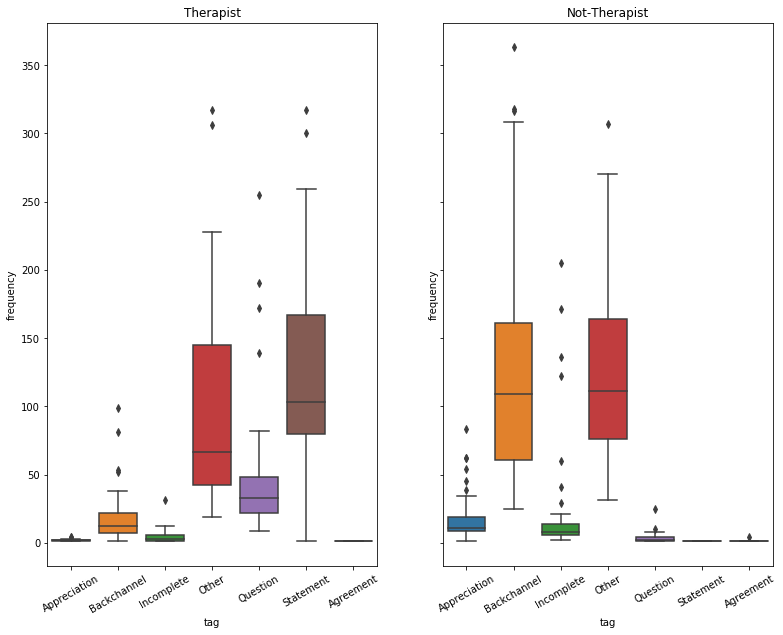

In [104]:
fig, axs = plt.subplots(ncols = 2, sharey = True)
g = sns.boxplot(x = 'tag',
            y = 'frequency', data = data[data['is_therapist'] == True],
            ax = axs[0]);
axs[0].set_title("Therapist")
g = sns.boxplot(x = 'tag',
            y = 'frequency',
            data = data[data['is_therapist'] == False],
            ax = axs[1]);
axs[1].set_title("Not-Therapist")
#plt.ylabel("Freq. of label");
#plt.title("Label frequency for therapist dialogue")

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)

plt.show();

# Therapist correlations
Calculate the spearman correlation between the frequency of each label and scores. 

_update Oct 4th_: Use a linear model instead of going one by one.


First, we create a matrix $X$ where rows are the families and columns are the number of times either therapist or non-therapist used each DA. We then fit a linear model to predict the corresponding COACH score.

## Therapist

In [120]:
therapist_d.columns

Index(['is_therapist', 'tag', 'frequency', 'FAMID', 'D1LNG', 'D1CDN', 'D1RTN',
       'D1SCO01', 'D1SCO02', 'D1SCO03', 'D1SCO04', 'D1SCO05', 'D2LNG', 'D2CDN',
       'D2RTN', 'D2SCO01', 'D2SCO02', 'D2SCO03', 'D2SCO04', 'D2SCO05', 'D3LNG',
       'D3CDN', 'D3RTN', 'D3SCO01', 'D3SCO02', 'D3SCO03', 'D3SCO04',
       'D3SCO05'],
      dtype='object')

In [127]:
therapist_d = data[data.is_therapist]
X = np.zeros((len(therapist_d.FAMID.unique()), len(therapist_d.tag.unique())))
Y = np.zeros((len(therapist_d.FAMID.unique()), 3, 5))

family_idx = {fam:i for i, fam in enumerate(therapist_d.FAMID.unique())}
tag_idx = {t:i for i, t in enumerate(therapist_d.tag.unique())}
coach_scores = {0:['D1SCO01', 'D1SCO02', 'D1SCO03', 'D1SCO04', 'D1SCO05'],
                1:['D2SCO01', 'D2SCO02', 'D2SCO03', 'D2SCO04', 'D2SCO05'],
                2:['D3SCO01', 'D3SCO02', 'D3SCO03', 'D3SCO04', 'D3SCO05']}


for idx, row in therapist_d.iterrows():
    i = family_idx[row['FAMID']]
    j = tag_idx[row['tag']]
    X[i, j] = row['frequency']

    for k, z in coach_scores.items():
        for l in range(len(z)):
            Y[i, k, l] = row[z[l]]
        
print(X.shape)
print(Y.shape)

(47, 7)
(47, 3, 5)


In [164]:
# Standarize columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X.shape

(47, 7)

In [167]:
X[:,0]

array([0.5 , 0.  , 0.25, 0.5 , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.25,
       0.  , 0.25, 0.  , 0.5 , 0.75, 0.25, 0.  , 0.5 , 0.25, 1.  , 0.25,
       0.  , 0.  , 0.  , 0.5 , 0.75, 1.  , 0.5 , 0.  , 0.25, 0.  , 0.5 ,
       0.  , 0.75, 0.25, 0.5 , 0.  , 0.  , 0.  , 0.5 , 0.25, 0.  , 0.  ,
       0.  , 0.  , 0.75])

In [168]:
# fit all models
models = []
for k in range(3):
    for score in range(5):
        models.append((k, score, sm.OLS(Y[:, k, score], X).fit()))

In [169]:
# Holm-bonferroni correction
def holmBonferroni(models):
    res_2 = sorted(models, key = lambda x: x[2].f_pvalue)
    m = len(res_2)

    k = 0
    while k < len(res_2) and res_2[k][2].f_pvalue < 0.05 / (m + 1 - k - 1):
        k += 1

    return res_2[:(k - 1)]

models_corr = [(coach_scores[k][l], m) for k, l, m in holmBonferroni(models)]

In [170]:
tag_idx.items()

dict_items([('Appreciation', 0), ('Backchannel', 1), ('Incomplete', 2), ('Other', 3), ('Question', 4), ('Statement', 5), ('Agreement', 6)])

In [172]:
len(models_corr)

4

## Results
 * D1SCO04 has a significant positive relation with Statement (x's start at 1 instead of 0)

In [171]:
score, model = models_corr[0]
print(score)
print(model.summary())

D1SCO04
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     31.64
Date:                Tue, 10 Sep 2019   Prob (F-statistic):           2.20e-14
Time:                        11:47:27   Log-Likelihood:                -91.908
No. Observations:                  47   AIC:                             197.8
Df Residuals:                      40   BIC:                             210.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3399      0.929      1.443 

* D1SCO05 has a significant positive relation with Agreement

In [173]:
score, model = models_corr[1]
print(score)
print(model.summary())

D1SCO05
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     30.87
Date:                Tue, 10 Sep 2019   Prob (F-statistic):           3.31e-14
Time:                        11:48:02   Log-Likelihood:                -93.984
No. Observations:                  47   AIC:                             202.0
Df Residuals:                      40   BIC:                             214.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6400      0.971      1.690 

* D1SCO01 has a significant positive relation with Statement

In [174]:
score, model = models_corr[2]
print(score)
print(model.summary())

D1SCO01
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     30.10
Date:                Tue, 10 Sep 2019   Prob (F-statistic):           5.02e-14
Time:                        11:48:51   Log-Likelihood:                -97.129
No. Observations:                  47   AIC:                             208.3
Df Residuals:                      40   BIC:                             221.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9746      1.038      1.903 

* D1SCO02 has a significant positive relation with Statement and with Appreciation

In [175]:
score, model = models_corr[3]
print(score)
print(model.summary())

D1SCO02
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     27.40
Date:                Tue, 10 Sep 2019   Prob (F-statistic):           2.32e-13
Time:                        11:49:45   Log-Likelihood:                -98.763
No. Observations:                  47   AIC:                             211.5
Df Residuals:                      40   BIC:                             224.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2974      1.074      2.138 